## CM2.6 Ocean Budgets Fields

The notebook below shows a real example of producing a dataset in zarr format. **This adds custom code for GFDL's tape archive (dmget).**

Note that it is always recommended to use the latest versions of xarray and zarr for this, since the technology is evolving very fast.

In [1]:
import xarray as xr
from glob import glob
import dask
import os
import shutil
import numpy as np
from dask.distributed import Client, LocalCluster
from matplotlib import pyplot as plt
import zarr
from dask.diagnostics import ProgressBar
import subprocess as sp

%matplotlib inline

In [2]:
zarr.__version__

'2.3.3.dev84'

In [3]:
xr.__version__

'0.14.1'

### Optional: Use a Dask Cluster

If the computer where you are producing the dataset can provide parallelism, it can speed things up a lot to use a dask cluster. Even if you are only using a small machine, using a distributed cluster is nice because it gives you lots of useful diagnostics and progress information via the dashboard.

For reference, the machine where this example was run is a large shared server with 36 Xeon CPU cores, 1TB of RAM, and ~400 TB of RAID-6 hard disk storage.

In [4]:
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33295 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.22 GB


### Open Source NetCDF Files

Rather than using globbing to find the source files, here I am being more explicit about which files I want to open. This is recommended if know the pattern and conventions that were used to produce the source files.

In [5]:
#experiment = 'CM2.6_A_Control-1860_V03'
experiment = 'CM2.6_A_V03_1PctTo2X'

exp_alias = {'CM2.6_A_Control-1860_V03': 'control',
             'CM2.6_A_V03_1PctTo2X': 'one_percent'}

base_dir = '/archive/wga/CM2.6'
ddir = os.path.join(base_dir, experiment, 'pp/ocean_budgets/av/annual_1yr')
prefix = 'ocean_budgets'
year_start, year_end = 181, 200
years = np.arange(year_start, year_end+1)
year_str = '%04d-%04d' % (year_start, year_end)
files = [os.path.join(ddir, '%s.%04d0101.nc' % (prefix, year))
         for year in years]

In [6]:
files[:2]

['/archive/wga/CM2.6/CM2.6_A_V03_1PctTo2X/pp/ocean_budgets/av/annual_1yr/ocean_budgets.01810101.nc',
 '/archive/wga/CM2.6/CM2.6_A_V03_1PctTo2X/pp/ocean_budgets/av/annual_1yr/ocean_budgets.01820101.nc']

In [7]:
# static file for coordinates
dstatic = os.path.join(base_dir, experiment, 'pp/ocean')
fstatic = os.path.join(dstatic, 'ocean.static.nc')

In [8]:
# GFDL site specific - unarchive from tape if necessary
cmd = f'dmget -v -d {ddir} *.nc'
_ = sp.check_call(cmd, shell=True)

cmd = f'dmget -v -d {dstatic} ocean.static.nc'
_ = sp.check_call(cmd, shell=True)

Here I define some more options related to opening the files. Specifically, I know I want to drop certain extraneous coordinates and auxilliary variables. 

**Performance tip:** Dropping coordinates when opening many files with xarray is generally a good idea, because xarray has to verify that the coordinates are identical in each file. The coordinates can then be added back to the concattenated dataset.

In [9]:
# these are variables I just want to drop forever
drop_vars = ['average_T1', 'average_T2', 'average_DT', 'time_bounds']
drop_vars += ['yt_ocean', 'xt_ocean', 'yu_ocean', 'xu_ocean',
              'grid_yu_ocean', 'grid_xu_ocean', 'grid_yt_ocean', 'grid_xt_ocean']
# therse are variables I want to drop while running `open_mfdataset` but then add back later
extra_coord_vars = ['geolon_t', 'geolat_t', 'geolon_c', 'geolat_c']
chunks = {'time': 'auto', 'st_ocean': 5, 'sw_ocean': 5}

open_kwargs = dict(drop_variables=(drop_vars + extra_coord_vars),
                   chunks=chunks, decode_cf=True, decode_times=False,
                   combine='by_coords')
ds = xr.open_mfdataset(files, parallel=True, **open_kwargs)

# add the extra coordinates back in from static file
ds0 = xr.open_dataset(fstatic, decode_cf=True, decode_times=False)[extra_coord_vars]
for cv in extra_coord_vars:
    ds.coords[cv] = ds0.coords[cv]
ds

<xarray.Dataset>
Dimensions:             (nv: 2, st_ocean: 50, sw_ocean: 50, time: 20, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
  * sw_ocean            (sw_ocean) float64 10.07 20.16 ... 5.29e+03 5.5e+03
  * st_ocean            (st_ocean) float64 5.034 15.1 ... 5.185e+03 5.395e+03
  * nv                  (nv) float64 1.0 2.0
  * time                (time) float64 6.593e+04 6.629e+04 ... 7.287e+04
    geolat_t            (yt_ocean, xt_ocean) float32 ...
  * yt_ocean            (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * xt_ocean            (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
    geolon_t            (yt_ocean, xt_ocean) float32 ...
    geolat_c            (yu_ocean, xu_ocean) float32 ...
  * yu_ocean            (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0
  * xu_ocean            (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.9 80.0
    geolon_c            (yu_ocean, xu_ocean) float32 ...
Data variables:
    wrhot               (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_tendency       (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_advection      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_submeso        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_vdiffuse_impl  (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_nonlocal_KPP   (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_rivermix       (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_eta_smooth     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    temp_xflux_adv      (time, st_ocean, yt_ocean, xu_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_yflux_adv      (time, st_ocean, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_zflux_adv      (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_yflux_submeso  (time, st_ocean, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    swflx               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sw_heat             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    sfc_hflux_pme       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sfc_hflux_coupler   (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    net_sfc_heating     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    frazil_2d           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_dzt             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    uhrho_et            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
Attributes:
    filename:                  01810101.ocean_budgets.nc
    title:                     CM2.6_miniBling
    grid_type:                 mosaic
    grid_tile:                 1
    history:                   Fri Apr 18 16:04:30 2014: ncks --64bit --hdr_p...
    nco_openmp_thread_number:  1
    NCO:                       4.1.0

In [10]:
# the attributes coordinates from netcdf conflicts with xarray own coordinates attr, hence removing it
for var in ds.variables:
    if 'coordinates' in ds[var].attrs:
        del ds[var].attrs['coordinates']

Do a sanity check on the input data.

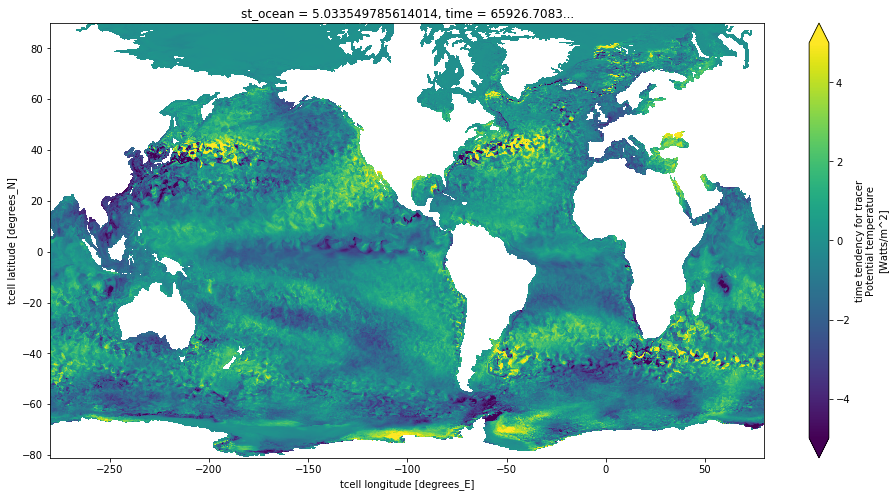

In [11]:
ds.temp_tendency.isel(time=0, st_ocean=0).load().plot(figsize=(16, 8), vmin=-5, vmax=5)

### Export to Zarr

I also define a custom compressor to use.

In [12]:
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)
encoding = {vname: {'compressor': compressor} for vname in ds.variables}
outdir_base = '/local2/home/zarr_stores/CM2.6'
dsname = prefix
outdir = os.path.join(outdir_base, exp_alias[experiment], dsname)
outdir

'/local2/home/zarr_stores/CM2.6/one_percent/ocean_budgets'

In [13]:
ds.nbytes / 1e9

549.141221776

In [14]:
with ProgressBar():
    zs = ds.to_zarr(outdir, encoding=encoding, consolidated=True)

### Verify Zarr Dataset

In [15]:
ds_z = xr.open_zarr(outdir, consolidated=True)
ds_z

<xarray.Dataset>
Dimensions:             (nv: 2, st_ocean: 50, sw_ocean: 50, time: 20, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
Coordinates:
    geolat_c            (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolat_t            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_c            (yu_ocean, xu_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
    geolon_t            (yt_ocean, xt_ocean) float32 dask.array<chunksize=(338, 450), meta=np.ndarray>
  * nv                  (nv) float64 1.0 2.0
  * st_ocean            (st_ocean) float64 5.034 15.1 ... 5.185e+03 5.395e+03
  * sw_ocean            (sw_ocean) float64 10.07 20.16 ... 5.29e+03 5.5e+03
  * time                (time) object 0181-07-01 17:00:00 ... 0200-07-01 14:00:00
  * xt_ocean            (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
  * xu_ocean            (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.9 80.0
  * yt_ocean            (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
  * yu_ocean            (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.96 90.0
Data variables:
    frazil_2d           (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    net_sfc_heating     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    rho_dzt             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    sfc_hflux_coupler   (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sfc_hflux_pme       (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    sw_heat             (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    swflx               (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    temp_advection      (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_eta_smooth     (time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 2700, 3600), meta=np.ndarray>
    temp_nonlocal_KPP   (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_rivermix       (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_submeso        (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_tendency       (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_vdiffuse_impl  (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_xflux_adv      (time, st_ocean, yt_ocean, xu_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_yflux_adv      (time, st_ocean, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_yflux_submeso  (time, st_ocean, yu_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    temp_zflux_adv      (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    uhrho_et            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
    wrhot               (time, sw_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 5, 2700, 3600), meta=np.ndarray>
Attributes:
    NCO:                       4.1.0
    filename:                  01810101.ocean_budgets.nc
    grid_tile:                 1
    grid_type:                 mosaic
    history:                   Fri Apr 18 16:04:30 2014: ncks --64bit --hdr_p...
    nco_openmp_thread_number:  1
    title:                     CM2.6_miniBling

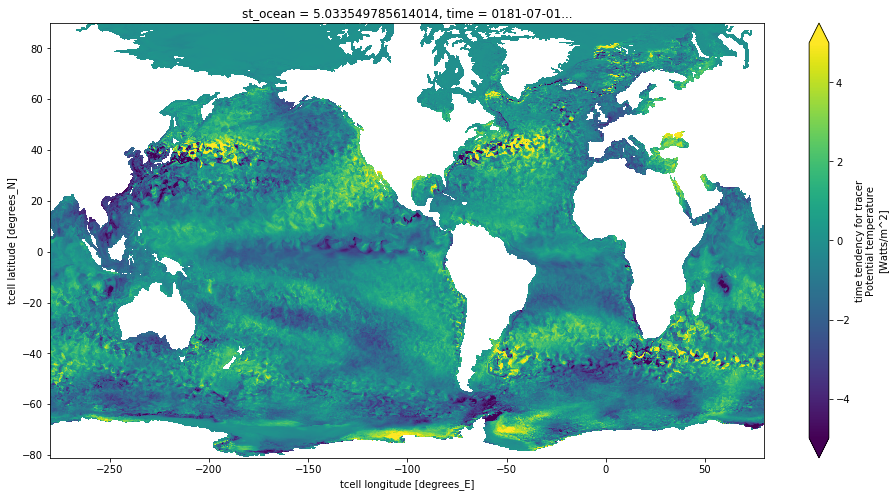

In [16]:
ds_z.temp_tendency.isel(time=0, st_ocean=0).load().plot(figsize=(16, 8), vmin=-5, vmax=5)

Look at zarr's own diagnostic info for one of the variables. There is lots of useful info in here.

In [17]:
zstore = zs.ds
zstore.temp_tendency.info

Name,/temp_tendency
Type,zarr.core.Array
Data type,float32
Shape,"(20, 50, 2700, 3600)"
Chunk shape,"(1, 5, 2700, 3600)"
Order,C
Read-only,False
Compressor,"Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,38880000000 (36.2G)
No. bytes stored,16367576626 (15.2G)
